# 0. Functions & Module Import

In [ ]:
import pandas as pd
import os
import sys
import urllib.request
import json
import re
import numpy as np
from google.colab import drive
from glob import glob

drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/work_dir')

pd.set_option('display.float_format', '{:.0f}'.format)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def get_book_descriptions(df, isbn_column, client_id, client_secret):
    """
    네이버 책 API를 통해 ISBN 번호를 바탕으로 책 설명을 가져오는 함수.

    Parameters:
    - df (pd.DataFrame): ISBN 번호가 있는 데이터프레임
    - isbn_column (str): ISBN 번호가 포함된 열의 이름
    - client_id (str): 네이버 API 클라이언트 ID
    - client_secret (str): 네이버 API 클라이언트 시크릿

    Returns:
    - pd.DataFrame: description 열이 추가된 데이터프레임
    """
    descriptions = []

    for isbn in df[isbn_column]:
        query = urllib.parse.quote(isbn)

        # 네이버 API URL
        url = f"https://openapi.naver.com/v1/search/book_adv?d_isbn={query}&display=1&start=1&sort=sim"

        # 요청 헤더 설정
        request = urllib.request.Request(url)
        request.add_header("X-Naver-Client-Id", client_id)
        request.add_header("X-Naver-Client-Secret", client_secret)

        try:
            # API 요청 보내기
            response = urllib.request.urlopen(request)
            rescode = response.getcode()

            if rescode == 200:
                # 응답 본문 읽기
                response_body = response.read()
                items = json.loads(response_body.decode('utf-8')).get("items", [])

                # HTML 태그 제거용 정규 표현식
                remove_tag = re.compile('<.*?>')

                # 책의 description 가져오기 (첫 번째 검색 결과)
                description = re.sub(remove_tag, '', items[0]['description']) if items else "No description available"
                descriptions.append(description)
            else:
                print(f"Error Code: {rescode}")
                descriptions.append("Error in fetching description")

        except urllib.error.HTTPError as e:
            print(f"HTTP Error: {e.code}")
            descriptions.append("HTTP Error")
        except urllib.error.URLError as e:
            print(f"URL Error: {e.reason}")
            descriptions.append("URL Error")
        except Exception as e:
            print(f"General Error: {str(e)}")
            descriptions.append("General Error")

    # DataFrame에 descriptions 열 추가
    df['description'] = descriptions

    return df

# 1. Data Preprocessing #1

## (1) 직접 수집 데이터

In [ ]:
df = pd.read_csv("NL_BO_BOOK_PUB_202408-1.csv", low_memory=False)
df.shape

(905763, 32)

In [ ]:
df = df[["TITLE_NM", "ISBN_THIRTEEN_NO", "SGVL_ISBN_NO",
         "ISBN_THIRTEEN_ORGT_NO", "KDC_NM"]]

In [ ]:
nan_count_per_column = df.isna().sum()
print(nan_count_per_column)

TITLE_NM                     1
ISBN_THIRTEEN_NO         55854
SGVL_ISBN_NO             83146
ISBN_THIRTEEN_ORGT_NO    87961
KDC_NM                   53628
dtype: int64


In [ ]:
df = df.dropna(subset=['KDC_NM'])

In [ ]:
nan_count_per_column = df.isna().sum()
print(nan_count_per_column)

TITLE_NM                     0
ISBN_THIRTEEN_NO         47018
SGVL_ISBN_NO             70738
ISBN_THIRTEEN_ORGT_NO    75217
KDC_NM                       0
dtype: int64


In [ ]:
df = df[["TITLE_NM", "ISBN_THIRTEEN_NO", "KDC_NM"]]
df

,TITLE_NM,ISBN_THIRTEEN_NO,KDC_NM
0,천 번 부리질,9788965775201,811.7
1,감정을 이해하는 그림책 큐레이션,9791194126027,181.7
2,흐르는 강물처럼,9791130649672,843.6
3,(조용헌의) 산사로 가는 길,9791171250974,226.911
4,(조용헌의) 봄여름가을겨울,9791169256032,226.911
...,...,...,...
905758,왜 양을 세야 해?,9788960986831,813.8
905759,파뿌리24,9791168440203,813.8
905760,파뿌리24,9791168440302,813.8
905761,파뿌리24,9791168440364,813.8


In [ ]:
df = df.dropna(subset=['ISBN_THIRTEEN_NO'])
nan_count_per_column = df.isna().sum()
print(nan_count_per_column)

TITLE_NM            0
ISBN_THIRTEEN_NO    0
KDC_NM              0
dtype: int64


In [ ]:
df['ISBN_THIRTEEN_NO'].duplicated().sum()

508170

In [ ]:
df = df.drop_duplicates(subset=['ISBN_THIRTEEN_NO'])
df.shape

(296947, 3)

## (2) 구축되어 있는 데이터

In [ ]:
"""
지정된 경로의 파일을 불러와 하나의 데이터프레임으로 병합합니다.
"""
csv_files = glob(os.path.join('/content/drive/MyDrive/work_dir', "NL_BO_SPECIES_MASTER_NEW*.csv"))

# 각 파일을 읽고 리스트에 추가하여 병합
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# 모든 데이터를 하나의 데이터프레임으로 결합
df_2 = pd.concat(dataframes, ignore_index=True)

<ipython-input-70-15d402cc761f>:9: DtypeWarning: Columns (6,11,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-70-15d402cc761f>:9: DtypeWarning: Columns (7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-70-15d402cc761f>:9: DtypeWarning: Columns (6,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-70-15d402cc761f>:9: DtypeWarning: Columns (11,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-70-15d402cc761f>:9: DtypeWarning: Columns (1,6,7,9,10,11,12,13,14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-70-15d402cc761f>:9: DtypeWarning: Columns (1,7,10,11,12,13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = p

In [ ]:
df_2.columns

Index(['SEQ_NO', 'ISBN_THIRTEEN_NO', 'VLM_NM', 'TITLE_NM', 'AUTHR_NM',
       'PUBLISHER_NM', 'PBLICTE_DE', 'ADTION_SMBL_NM', 'PRC_VALUE',
       'IMAGE_URL', 'BOOK_INTRCN_CN', 'KDC_NM', 'TITLE_SBST_NM',
       'AUTHR_SBST_NM', 'TWO_PBLICTE_DE', 'INTNT_BOOKST_BOOK_EXST_AT',
       'PORTAL_SITE_BOOK_EXST_AT', 'ISBN_NO'],
      dtype='object')

In [ ]:
df_2 = df_2[["TITLE_NM", "ISBN_THIRTEEN_NO", "BOOK_INTRCN_CN", "KDC_NM"]]

In [ ]:
df_2 = df_2.dropna(subset=['KDC_NM'])
nan_count_per_column = df_2.isna().sum()
print(nan_count_per_column)

TITLE_NM                  0
ISBN_THIRTEEN_NO          0
BOOK_INTRCN_CN      1392396
KDC_NM                    0
dtype: int64


In [ ]:
df_2 = df_2.dropna(subset=['BOOK_INTRCN_CN'])
nan_count_per_column = df_2.isna().sum()
print(nan_count_per_column)

TITLE_NM            0
ISBN_THIRTEEN_NO    0
BOOK_INTRCN_CN      0
KDC_NM              0
dtype: int64


In [ ]:
df_2.shape

(1050904, 4)

In [ ]:
df_2 = df_2.drop_duplicates(subset=['ISBN_THIRTEEN_NO'])
df_2.shape

(860476, 4)

In [ ]:
duplicate_counts = df_2['BOOK_INTRCN_CN'].value_counts()
# 중복된 값만 필터링 (2번 이상 나타나는 값)
duplicates = duplicate_counts[duplicate_counts > 1]

print(duplicates)

BOOK_INTRCN_CN
[해외주문원서] 고객님의 요청으로 수입 주문하는 도서이므로, 주문취소 및 반품이 불가합니다. (단, 재고부족인 경우는 가능)                                                                                                                           4966
이 책은 해당 분야 전공자들을 위한 교재 겸 전문서이다.                                                                                                                                                                  255
▶ 이 책은 영어로 구성되어 있습니다.                                                                                                                                                                            208
어린이들을 위한 음악교재이다. 어린이들이 쉽게 따라할 수 있도록 구성되어 있다.                                                                                                                                                     199
명문대 선정 세계문학 시리즈. 우리 나라의 대표적인 아동문학가들이 초등학교 아이들이 읽기에 알맞은 작품을 선정, 다듬어 실었다. 또 책 뒤에는 명문대학 국문과 교수들이 해설한 작가의 작품론과 철학과 교수들이 출제한 논술 길잡이를 수록했다.                                                            142


In [ ]:
# 삭제할 행을 찾기 위한 조건 설정
df_2 = df_2[df_2['BOOK_INTRCN_CN'] != "[해외주문원서] 고객님의 요청으로 수입 주문하는 도서이므로, 주문취소 및 반품이 불가합니다. (단, 재고부족인 경우는 가능)"]
df_2.shape

(855510, 4)

In [ ]:
df_2.rename(columns={"BOOK_INTRCN_CN": "description"}, inplace=True)

In [ ]:
"""
# 출력 옵션 설정: 최대 열과 행 제한을 증가시킴
pd.set_option('display.max_colwidth', None)  # 열의 최대 길이를 제한하지 않음
pd.set_option('display.max_rows', None)  # 행 수 제한을 제거
shortest_description_length = df_2['description'].apply(len).max()
shortest_description = df_2[df_2['description'].apply(len) == shortest_description_length]['description']
print(shortest_description.to_string(index=False))
"""

function previewStoryPopup(no)  {   var url = &quot;http://www.doosandonga.com/file/productdetail/page/book&quot; + no + &quot;.htm&quot;;   var isscroll = &quot;no&quot;;   var scroll_width = 0;    if (no == &quot;1&quot; || no == &quot;2&quot; || no == &quot;6&quot; || no == &quot;7&quot; || no == &quot;8&quot; || no == &quot;11&quot; || no == &quot;12&quot; || no == &quot;13... 


In [ ]:
average_length = df_2['description'].apply(len).mean()
print(average_length)

139.32334397026335


## KDC 라벨 분포 확인

In [ ]:
label_counts = df['KDC_NM'].value_counts()
high_freq_labels = label_counts[label_counts >= 1000]
high_freq_labels

,count
KDC_NM,
814,6544
830,6046
814,5921
843,3522
812,2788
810,2447
410,2063
834,1810
375,1787


#2. 책 소개 데이터 수집

In [ ]:
# 100개씩 나누기
df_chunks = np.array_split(df, len(df) // 100 + 1)

# 결과 확인
for i, chunk in enumerate(df_chunks):
    print(f"Chunk {i+1}:")
    print(chunk)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
...                   ...              ...    ...
780718  킹피셔 어린이 세계사 백과사전.    9788970574752    909
780719  킹피셔 어린이 세계사 백과사전.    9788970574769    909
780720  킹피셔 어린이 세계사 백과사전.    9788970574776    909
780721  킹피셔 어린이 세계사 백과사전.    9788970574783    909
780722  킹피셔 어린이 세계사 백과사전.    9788970574790    909

[100 rows x 3 columns]
Chunk 2672:
                     TITLE_NM ISBN_THIRTEEN_NO KDC_NM
780729  일본이 바다에 가라앉을지도 모른다구요？    9788952919021    445
780734                그림이랑 놀자    9788990627728    650
780738                까마귀 알퐁스    9788989427216    853
780742               나는 쇠무릎이야    9788988578988  813.8
780745                오줌 쏴아아！    9788901025858    210
...                       ...              ...    ...
780975                      말    9788901040622    408
780982                비주얼 박물관    9788901029702    010
781010            고향을 지키는 아이들    9788936440091  813.8
781014                 작은 그림책    9788936440176  813.8
781018               나는 둥그배미야    9

## 10/10

In [ ]:
for i in range(0, 11):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(11, 16):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(16, 21):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(21, 26):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(26, 31):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(31, 41):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(41, 51):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(51, 61):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

## 10/12

In [ ]:
for i in range(61, 81):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(81, 101):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(101, 151):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(151, 171):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(171, 200):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(200, 221):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(200, 251):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(265, 301):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

## 10/18

In [ ]:
for i in range(301, 321):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(301, 311):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(311, 321):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(321, 351):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

## 11/1

In [ ]:
for i in range(351, 371):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

##11/12

In [ ]:
for i in range(371, 400):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(400, 450):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(450, 480):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(480, 500):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(500, 550):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(510, 600):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
for i in range(600, 630):
    chunk_with_descriptions = get_book_descriptions(df_chunks[i], 'ISBN_THIRTEEN_NO', '4ZGwbwRE6gbsvIrE2ogN', 'Ya1mE4urmK')
    file_path = f'/content/drive/MyDrive/work_dir/chunk{i}.csv'
    chunk_with_descriptions.to_csv(file_path, index=False)

In [ ]:
!pip install transformers torch

# 2. Model with Title

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import Adam
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, roc_auc_score
from tqdm import tqdm
import copy

##Data Preprocessing #2

In [ ]:
def load_and_combine_csv(directory_path):
    """
    지정된 경로의 chunk*.csv 파일을 불러와 하나의 데이터프레임으로 병합합니다.
    """
    csv_files = glob(os.path.join(directory_path, "chunk*.csv"))

    # 각 파일을 읽고 리스트에 추가하여 병합
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)

    # 모든 데이터를 하나의 데이터프레임으로 결합
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

In [ ]:
combined_df = load_and_combine_csv("/content/drive/MyDrive/work_dir")
combined_df

,TITLE_NM,ISBN_THIRTEEN_NO,KDC_NM,description
0,천 번 부리질,9788965775201,812,『천 번 부리질』은 저자 이근영의 주옥같은 작품을 만나볼 수 있는 책이다.
1,감정을 이해하는 그림책 큐레이션,9791194126027,182,“두꺼운 이론서나 백 번의 강의보다 \n한 권의 그림책이 감정을 더 직관적으로 설명...
2,흐르는 강물처럼,9791130649672,844,운명의 파도에 맞서는 인간의 회복력에 대한 경이로운 데뷔작\n『가재가 노래하는 곳』...
3,(조용헌의) 산사로 가는 길,9791171250974,227,그 이름이 하나의 장르! 강호 동양학자 조용헌의 우리 사찰 깊이 읽기\n\n우리의 ...
4,(조용헌의) 봄여름가을겨울,9791169256032,227,때때로 찾아가 에너지를 얻는 ‘나만의 명당’이 있는가?\n봄여름가을겨울 계절 따라 ...
...,...,...,...,...
62995,"(장인과 닥나무가 함께 만든 역사,)조선의 과학기술사",9791156122500,409,인기 만점 조공 물품에서 갑옷 재료까지\n‘조선의 반도체’ 닥종이 톺아보기\n\n촘...
62996,이토록 재미있는 새 이야기 :눈 깜짝할 새 읽는 조류학,9791159714313,498,깃털의 형태에서부터 비행의 원리와 이동의 여정까지\n조류학자들이 들려주는 새에 대한...
62997,탐조일기,9791198219800,498,"젊은 탐조인 삽사롱의 \n새 보는 만화\n\n조류의 생태, 서식지 등을 관찰하고 탐..."
62998,엄마가 알려주는 초등 영어 레벨업,9791192575971,375,초등 입학을 기점으로 영어를 시작하는 부모님들은 조급함을 숨기지 못합니다. 영유 나...


In [ ]:
combined_df = combined_df[combined_df['description'] != "No description available"]
combined_df

,TITLE_NM,ISBN_THIRTEEN_NO,KDC_NM,description
0,천 번 부리질,9788965775201,812,『천 번 부리질』은 저자 이근영의 주옥같은 작품을 만나볼 수 있는 책이다.
1,감정을 이해하는 그림책 큐레이션,9791194126027,182,“두꺼운 이론서나 백 번의 강의보다 \n한 권의 그림책이 감정을 더 직관적으로 설명...
2,흐르는 강물처럼,9791130649672,844,운명의 파도에 맞서는 인간의 회복력에 대한 경이로운 데뷔작\n『가재가 노래하는 곳』...
3,(조용헌의) 산사로 가는 길,9791171250974,227,그 이름이 하나의 장르! 강호 동양학자 조용헌의 우리 사찰 깊이 읽기\n\n우리의 ...
4,(조용헌의) 봄여름가을겨울,9791169256032,227,때때로 찾아가 에너지를 얻는 ‘나만의 명당’이 있는가?\n봄여름가을겨울 계절 따라 ...
...,...,...,...,...
62995,"(장인과 닥나무가 함께 만든 역사,)조선의 과학기술사",9791156122500,409,인기 만점 조공 물품에서 갑옷 재료까지\n‘조선의 반도체’ 닥종이 톺아보기\n\n촘...
62996,이토록 재미있는 새 이야기 :눈 깜짝할 새 읽는 조류학,9791159714313,498,깃털의 형태에서부터 비행의 원리와 이동의 여정까지\n조류학자들이 들려주는 새에 대한...
62997,탐조일기,9791198219800,498,"젊은 탐조인 삽사롱의 \n새 보는 만화\n\n조류의 생태, 서식지 등을 관찰하고 탐..."
62998,엄마가 알려주는 초등 영어 레벨업,9791192575971,375,초등 입학을 기점으로 영어를 시작하는 부모님들은 조급함을 숨기지 못합니다. 영유 나...


In [ ]:
average_length = combined_df["description"].astype(str).apply(len).mean()
print(average_length)

533.0026045366293


In [ ]:
# 기존 구축 데이터 병합
combined_df = pd.concat([combined_df, df_2], ignore_index=True)

In [ ]:
combined_df

,TITLE_NM,ISBN_THIRTEEN_NO,KDC_NM,description
0,천 번 부리질,9788965775201,812,『천 번 부리질』은 저자 이근영의 주옥같은 작품을 만나볼 수 있는 책이다.
1,감정을 이해하는 그림책 큐레이션,9791194126027,182,“두꺼운 이론서나 백 번의 강의보다 \n한 권의 그림책이 감정을 더 직관적으로 설명...
2,흐르는 강물처럼,9791130649672,844,운명의 파도에 맞서는 인간의 회복력에 대한 경이로운 데뷔작\n『가재가 노래하는 곳』...
3,(조용헌의) 산사로 가는 길,9791171250974,227,그 이름이 하나의 장르! 강호 동양학자 조용헌의 우리 사찰 깊이 읽기\n\n우리의 ...
4,(조용헌의) 봄여름가을겨울,9791169256032,227,때때로 찾아가 에너지를 얻는 ‘나만의 명당’이 있는가?\n봄여름가을겨울 계절 따라 ...
...,...,...,...,...
897739,노인과 바다,9791167910691,747,푸른 바다를 배경으로 펼쳐지는 인간과 자연과의 교감을 다룬 대 서사시. 기존의 평범...
897740,내 옷은 플라스틱이야 - 재활용,9791161724348,539,환경 운동가의 검토와 추천을 거친 저학년 환경 그림책 시리즈. &lt;내 옷은 플라...
897741,구름만큼 큰 대답,9791158543365,812,"매일 반짝임이 달라지는 울진의 바닷가, 그곳에서 정미정 동시 작가와 함께 그림을 그..."
897742,한 번에 끝내는 중학 한국사 1~2 세트 - 전2권 - ① 선사 시대부터 고려 시대...,9791188762330,911,사전 지식이 부족해도 얼마든지 쉽고 재미있게 한국사를 공부할 수 있다. 교과서와 참...


In [ ]:
"""
# title, description 토큰 크기 히스토그램
# KoBERT 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')

# TITLE_NM과 description 열 결합
combined_df['combined_text'] = combined_df['TITLE_NM'] + " " + combined_df['description'].fillna('')

# 각 텍스트에 대해 토큰 길이 추출
token_lengths = [len(tokenizer.tokenize(text)) for text in combined_df['combined_text']]

# 히스토그램 생성
plt.hist(token_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlim(0, 1000)
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.show()
"""

'\n# title, description 토큰 크기 히스토그램\n# KoBERT 토크나이저 불러오기\ntokenizer = BertTokenizer.from_pretrained(\'monologg/kobert\')\n\n# TITLE_NM과 description 열 결합\ncombined_df[\'combined_text\'] = combined_df[\'TITLE_NM\'] + " " + combined_df[\'description\'].fillna(\'\')\n\n# 각 텍스트에 대해 토큰 길이 추출\ntoken_lengths = [len(tokenizer.tokenize(text)) for text in combined_df[\'combined_text\']]\n\n# 히스토그램 생성\nplt.hist(token_lengths, bins=20, color=\'skyblue\', edgecolor=\'black\')\nplt.xlim(0, 1000)\nplt.xlabel(\'Token Length\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Token Length Distribution\')\nplt.show()\n'

In [ ]:
combined_label_counts = combined_df['KDC_NM'].value_counts()

# 100개 이상인 라벨만 필터링
combined_high_freq_labels = combined_label_counts[combined_label_counts >= 100].index
combined_df_100 = combined_df[combined_df['KDC_NM'].isin(combined_high_freq_labels)]

In [ ]:
combined_df_100.shape

(687507, 4)

In [ ]:
len(combined_df_100['KDC_NM'].unique())

1238

## Model 구축

In [ ]:
class KDC_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.titles = dataframe['TITLE_NM'].tolist()
        self.descriptions = dataframe['description'].tolist()
        self.labels = dataframe['KDC_NM'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

        # KDC_NM의 고유 값들을 숫자로 매핑
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(dataframe['KDC_NM'].unique()))}

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title = str(self.titles[idx])
        description = str(self.descriptions[idx])
        label = self.labels[idx]  # 원래 레이블 가져오기

        # 라벨이 매핑에 있는지 확인
        if label not in self.label_to_index:
            raise ValueError(f"Label '{label}' not found in label mapping.")

        # 변환된 라벨
        label_idx = self.label_to_index[label]

        inputs = self.tokenizer(
            text=title + " " + description,
            padding='max_length',
            max_length=self.max_len,
            truncation=True,
            return_tensors="pt"
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label_idx, dtype=torch.long),
        }

In [ ]:
# 평가 함수 정의
def evaluate(loader, model):
    model.eval()
    all_predictions, all_labels, all_probabilities = [], [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            probabilities = torch.softmax(logits, dim=1).cpu().numpy()
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            all_probabilities.extend(probabilities)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    roc_auc = roc_auc_score(all_labels, all_probabilities, multi_class='ovr')

    return avg_loss, accuracy, f1, recall, precision, roc_auc

In [ ]:
# KoBERT 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
# 데이터프레임의 KDC_NM 열을 문자열로 변환하여 정렬 오류 방지
combined_df_100['KDC_NM'] = combined_df_100['KDC_NM'].astype(str)
dataset = KDC_Dataset(combined_df_100, tokenizer=tokenizer, max_len=512)
# KDC 라벨 수에 맞게 설정 (예: 10개의 라벨)
num_kdc_labels = 1238
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=num_kdc_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
<ipython-input-34-36b307b28448>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_100['KDC_NM'] = combined_df_100['KDC_NM'].astype(str)


config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 데이터셋 분할
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

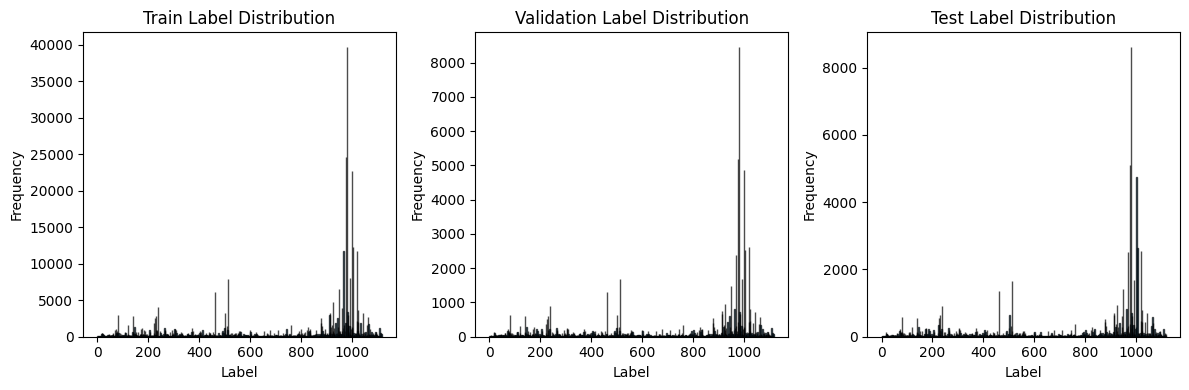

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 라벨 추출 (각 데이터셋에 대해 라벨을 확인)
train_labels = [sample['label'].item() for sample in train_dataset]
val_labels = [sample['label'].item() for sample in val_dataset]
test_labels = [sample['label'].item() for sample in test_dataset]

# 라벨 분포 시각화
plt.figure(figsize=(12, 4))

# Train 데이터셋 라벨 분포
plt.subplot(1, 3, 1)
plt.hist(train_labels, bins=np.arange(min(train_labels), max(train_labels)+1, 1), edgecolor='black', alpha=0.7)
plt.title('Train Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Validation 데이터셋 라벨 분포
plt.subplot(1, 3, 2)
plt.hist(val_labels, bins=np.arange(min(val_labels), max(val_labels)+1, 1), edgecolor='black', alpha=0.7)
plt.title('Validation Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Test 데이터셋 라벨 분포
plt.subplot(1, 3, 3)
plt.hist(test_labels, bins=np.arange(min(test_labels), max(test_labels)+1, 1), edgecolor='black', alpha=0.7)
plt.title('Test Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# 하이퍼 파라미터 값
best_val_loss = float('inf')
patience = 2  # 성능 개선이 없을 때 조기 종료를 위한 patience 값
trigger_times = 0  # 성능 개선이 없을 때 카운트
best_model_state = None

# Define the number of epochs here
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = Adam(model.parameters(), lr=2e-5)

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_predictions, all_labels, all_probabilities = [], [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        probabilities = torch.softmax(logits, dim=1).detach().cpu().numpy()
        predictions = torch.argmax(logits, dim=1).detach().cpu().numpy()

        all_probabilities.extend(probabilities)
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    roc_auc = roc_auc_score(all_labels, all_probabilities, multi_class='ovr')

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, "
          f"F1: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, ROC AUC: {roc_auc:.4f}")

    # 검증 셋 평가
    val_loss, val_accuracy, val_f1, val_recall, val_precision, val_roc_auc = evaluate(val_loader, model)
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, "
          f"F1: {val_f1:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}, ROC AUC: {val_roc_auc:.4f}")

    # Early Stopping 체크
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())  # 가장 좋은 모델 가중치 저장
        trigger_times = 0  # 개선이 있었으므로 trigger_times 초기화
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

# 학습 종료 후, 가장 좋은 모델 가중치 로드
model.load_state_dict(best_model_state)

# 최종 테스트 셋 평가
test_loss, test_accuracy, test_f1, test_recall, test_precision, test_roc_auc = evaluate(test_loader, model)
print(f"Test Set - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, "
      f"F1: {test_f1:.4f}, Recall: {test_recall:.4f}, Precision: {test_precision:.4f}, ROC AUC: {test_roc_auc:.4f}")

Training Epoch 1/10:  66%|██████▌   | 9894/15040 [7:32:33<3:55:23,  2.74s/it]


KeyboardInterrupt: 